In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score


fim_posicao= pd.read_excel('fim_posicao_queen.xlsx', sheet_name=0)
meio_posicao= pd.read_excel('meio_posicao_queen.xlsx', sheet_name=0)

In [9]:
df = meio_posicao.copy()
features = ['bom', 'ruim', 'media', 'idade']
X = df[features]
y = df['vencedora']

In [10]:
groups = df['tempfranquia']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
gss

GroupShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None)

In [11]:
train_idx, test_idx = next(gss.split(X, y, groups=groups))

In [12]:
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print("Temporadas no treino:", df['tempfranquia'].iloc[train_idx].unique())
print("Temporadas no teste:", df['tempfranquia'].iloc[test_idx].unique())

Temporadas no treino: [ 201  301  401  501  701  801  901 1001 1101 1201 1301 1401 1501 1601
  102  202  302  402  502  602  103  204  304  404  504  109  105  205
  305 1011 3011 4011 1013 2013 3013 1015 3015 2014 3014 1012 2012 1016
  307  203 1801 1901]
Temporadas no teste: [ 101  601  104  209 2011 2015 1014  106  206 1018 1701 1802]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


0      1
1      0
2      0
3      0
4      0
      ..
490    0
491    0
492    0
493    0
494    0
Name: vencedora, Length: 102, dtype: int64

In [15]:
# REGRESSÃO LINEAR
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
probabilidades_vencedora = logreg.predict_proba(X_test_scaled)
probs = probabilidades_vencedora[:, 1]  # pegar só probabilidade de vencer

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.69      0.82        91
           1       0.28      1.00      0.44        11

    accuracy                           0.73       102
   macro avg       0.64      0.85      0.63       102
weighted avg       0.92      0.73      0.78       102

[[63 28]
 [ 0 11]]


In [17]:
probabilidades = probabilidades_vencedora[:, 1]

# Crie um DataFrame para visualizar os resultados
# Lembre-se que o X_test precisa ter os nomes das queens para esta visualização
# Use o índice do X_test para pegar as rainhas do DataFrame original
queens_do_teste =meio_posicao.loc[X_test.index, 'queen']

# Crie um DataFrame para visualizar os resultados
resultados = pd.DataFrame({
    'queen': queens_do_teste,
    'Chance de Vencer (%)': probabilidades * 100
})

resultados['Chance de Vencer (%)'] = resultados['Chance de Vencer (%)'].round(2)

print("--- Chance de cada rainha ganhar ---")
print(resultados.sort_values(by='Chance de Vencer (%)', ascending=False))

--- Chance de cada rainha ganhar ---
              queen  Chance de Vencer (%)
42   Bianca Del Rio                 91.99
468      Onya Nurve                 87.62
310        Sharonne                 85.85
46     BenDeLaCreme                 84.40
264      Keta Minaj                 83.88
..              ...                   ...
318   Jota Carajota                  0.22
6           Akashia                  0.11
216    Tynomi Banks                  0.09
441   Serena Morena                  0.03
458  Tessa Testicle                  0.02

[102 rows x 2 columns]


In [18]:
roc_auc = roc_auc_score(y_test, probs)
print("ROC-AUC:", roc_auc)
print("-------------------------------")
df_ranking = pd.DataFrame({
    "queen": df.loc[y_test.index, "queen"],
    "temporada": df.loc[y_test.index, "tempfranquia"],
    "real": y_test,
    "prob_vencer": probs
})

# ordenar por probabilidade de vencer
df_ranking = df_ranking.sort_values(["temporada", "prob_vencer"], ascending=[True, False])

# ver top 1 ou top 2 de cada temporada
top_1 = df_ranking.groupby("temporada").head(1)
print(top_1)


ROC-AUC: 0.8591408591408591
-------------------------------
                 queen  temporada  real  prob_vencer
1         Nina Flowers        101     0     0.815733
209          Rita Baga        104     0     0.806037
442          Leexa Fox        106     0     0.744188
443          Eva Blunt        206     1     0.500287
264         Keta Minaj        209     0     0.838809
42      Bianca Del Rio        601     1     0.919934
392       Viñas DeLuxe       1014     0     0.778765
452         Metamorkid       1018     1     0.651597
468         Onya Nurve       1701     1     0.876185
490  Kennedy Davenport       1802     0     0.778679
310           Sharonne       2011     1     0.858534
374              Piche       2015     0     0.801984


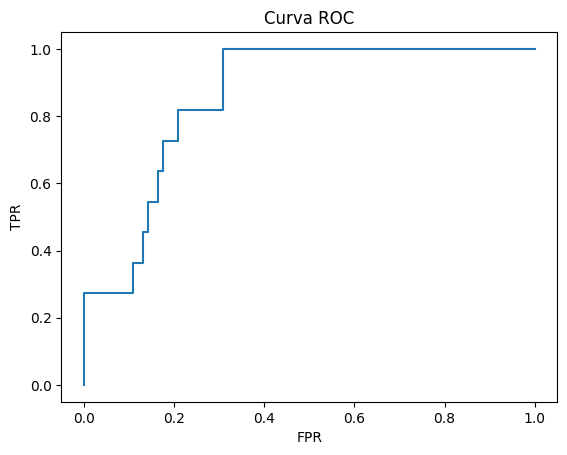

In [19]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.show()
